In [1]:
#Preamble
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import pickle
import emcee
import corner

In [2]:
def generateEllipse(a,b,centerX,centerY, grid):
    for x in range(len(grid)):
        for y in range(len(grid[0])):
            if ((x-centerX)/a)*((x-centerX)/a) + ((y-centerY)/b)*((y-centerY)/b) <= 1:
                grid[x][y] = 1
    
    return grid

In [3]:
def transitSim(a,b,r, speed, times, tref):
    ab = a/b
    br = b/r
    
    tmin = tref - 1/(2*speed)
    tmax = tref + 1/(2*speed)
    transitTimes = [t for t in times if t >= tmin and t <= tmax]
    flux = [1 for t in times if t < tmin]
    differences = []
    for i in range(1,len(transitTimes)):
        differences.append(transitTimes[i] - transitTimes[i-1])
    
    minDiff = np.min(differences)
    intDiffs = [int(d/minDiff) for d in differences]
    length = np.sum(intDiffs)
    
    
    res = int((2*(b+r))/length)
    if res < 1:
        res = 1
    rnew = int(res*length/(2*(1+br)))
    bnew = int(br*rnew)
    anew = int(ab*bnew)
    newIntDiffs = [res*i for i in intDiffs]
    print(res)
    print(np.sum(newIntDiffs))
    print(2*(rnew+bnew))
    
    starGrid = np.zeros([2*rnew, 4*bnew+2*rnew+4])
    ellipseGrid = np.zeros([2*rnew, 4*bnew+2*rnew+4])
    starGrid = generateEllipse(rnew,rnew,rnew, 2*bnew+rnew, starGrid)
    ellipseGrid = generateEllipse(anew,bnew,rnew,3*bnew+2*rnew + 2,ellipseGrid)
    planetGrid = np.ones([2*rnew,4*bnew+2*rnew+ 4]) - ellipseGrid
    fluxGrid = np.multiply(starGrid,planetGrid)
    initialFlux = np.sum(fluxGrid)
    
    for i in newIntDiffs:
        for j in range(i):
            planetGrid = np.delete(planetGrid,0,1)
            planetGrid = np.append(planetGrid,np.ones([2*rnew,1]),1)
            
        
        fluxGrid = np.multiply(starGrid,planetGrid)
        percentFlux = np.sum(fluxGrid)/initialFlux
        flux.append(percentFlux)
        
    for t in times:
        if t > tmax:
            flux.append(1)
    
    flux.append(1)
    return flux

In [ ]:
def logLikelihood(theta, times, flux, fluxErr):
    """
    Calculates the log likelihood based on the difference between the model and the data
    
    Args:
        theta (list) - parameters of the model
        times (list) - time array of the light curve
        flux (list) - array of flux data points
        fluxErr (list) - array of errors for the flux data points
    
    Returns:
        lnl (float) - log likelihood for the given theta values
    """
    xdim, ydim, velocity, tRef = theta
    fluxPredicted = transitSim(xdim, ydim,50,velocity,times, tRef)
    lnl = -np.sum(((flux - fluxPredicted)**2) /(2*fluxErr**2))
    return lnl

In [4]:
def getData(filename): 
    """
    Reads the necessary data from the elanor pipeline TESS lightcurve pickle files
    
    Args:
        filename (string) - name of the pickle file excluding the .pkl extension
        
    Returns:
        times (list) - list of times of observations in moditied julian day
        flux (list) - list of normalized flux values
        err (list) - list of error for the flux values
    """
    fp = open("./"+filename+".pkl","rb") 
    data = pickle.load(fp)##Unpickles the file
    fp.close()
    
    q = data[11]==0 ##Get the locations of high quality data
    times = data[6][q]##Take only high quality data
    flux = data[9][q]
    maxFlux = np.median(flux)
    flux /= maxFlux ##Normalize flux
    err = np.ones_like(flux)*np.nanstd(np.diff(flux))##Calculate error
    err /= np.sqrt(2)
    return times, flux, err

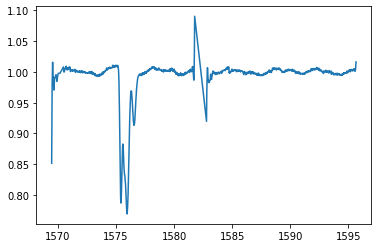

In [7]:
times, flux, _ = getData("lcs/tesslc_400799224")
fig = plt.subplot()
fig.plot(times, flux)
plt.show()